# **MODELO KNN**

In [101]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [102]:
from sklearn.model_selection import (
    train_test_split,
    cross_val_score,
    GridSearchCV,
    )

In [103]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    accuracy_score,
    f1_score,
    roc_auc_score,
    roc_curve,
    fbeta_score,
    recall_score
    )

In [104]:
from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')

In [105]:
# Configurações visuais
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# **Carregando o dataset tratado**

In [106]:
# Dataset de treino
df_train = pd.read_csv('fetal_health_train.csv')
# Dataset de teste
df_test = pd.read_csv('fetal_health_test.csv')

# **Separando features e target**

In [126]:
# Separando features e target
X_train = df_train.drop('fetal_health', axis=1)
y_train = df_train['fetal_health']
X_test = df_test.drop('fetal_health', axis=1)
y_test = df_test['fetal_health']

print(f"Dimensões dos dados:")
print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"y_test: {y_test.shape}")

Dimensões dos dados:
X_train: (1479, 11)
y_train: (1479,)
X_test: (634, 11)
y_test: (634,)


# **Verificando se os dados já foram escalonados**

In [108]:
print("\nVerificando escala dos dados (primeiras 5 amostras):")
print("Médias das features:", X_train.mean().values[:5])
print("Desvios padrão das features:", X_train.std().values[:5])


Verificando escala dos dados (primeiras 5 amostras):
Médias das features: [0.00965904 0.2034032  3.43475321 0.08908046 0.62136579]
Desvios padrão das features: [ 0.70090146  0.64640127 16.49793954  0.72701642  0.96416329]


###**Modelo multiclasse**

In [127]:
# Modelo KNN básico (k=5 é um valor comum inicial)
knn_multi = KNeighborsClassifier(n_neighbors=5)
knn_multi.fit(X_train, y_train)
y_pred = knn_multi.predict(X_test)


Matriz de Confusão:
[[474  17   3]
 [ 36  45   7]
 [  4  12  36]]


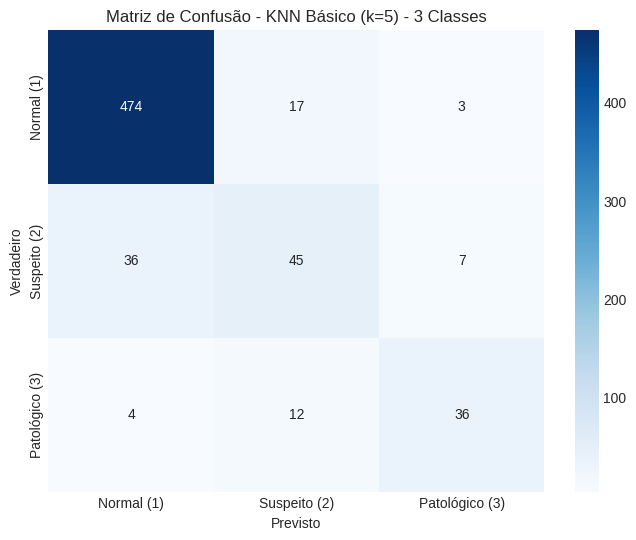

In [128]:
# Matriz de confusão
cm = confusion_matrix(y_test, y_pred)

print("\nMatriz de Confusão:")
print(cm)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal (1)', 'Suspeito (2)', 'Patológico (3)'],
    yticklabels=['Normal (1)', 'Suspeito (2)', 'Patológico (3)']
    )

plt.title('Matriz de Confusão - KNN Básico (k=5) - 3 Classes')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

In [129]:
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Relatório de Classificação:
              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94       494
         2.0       0.61      0.51      0.56        88
         3.0       0.78      0.69      0.73        52

    accuracy                           0.88       634
   macro avg       0.77      0.72      0.74       634
weighted avg       0.87      0.88      0.87       634



# **MÉTRICAS POR CLASSE (Foco em Recall e F2-Score)**

In [111]:
def calcular_f2_por_classe(y_true, y_pred):
    f2_scores = {}
    for classe in [1, 2, 3]:
        f2_scores[classe] = fbeta_score(
            y_true,
            y_pred,
            beta=2,
            labels=[classe],
            average=None,
            )[0]
    return f2_scores

#Cálculo de recall por classe
recalls = {}
for classe in [1, 2, 3]:
    recalls[classe] = recall_score(
        y_test,
        y_pred,
        labels=[classe],
        average=None
        )[0]

f2_scores = calcular_f2_por_classe(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

print(f"Acurácia geral: {accuracy:.4f}")
print("\nPor classe:")
for classe in [1, 2, 3]:
    nome_classe = {1: 'Normal', 2: 'Suspeito', 3: 'Patológico'}[classe]
    print(f"  {nome_classe} ({classe}):")
    print(f"    Recall: {recalls[classe]:.4f}  |  F2-Score: {f2_scores[classe]:.4f}")

# Foco especial na classe 3 (Patológica)
print(f"\nFOCO NA CLASSE 3 (PATOLÓGICA):")
print(f"  Recall: {recalls[3]:.4f}  |  F2-Score: {f2_scores[3]:.4f}")

Acurácia geral: 0.8754

Por classe:
  Normal (1):
    Recall: 0.9595  |  F2-Score: 0.9518
  Suspeito (2):
    Recall: 0.5114  |  F2-Score: 0.5282
  Patológico (3):
    Recall: 0.6923  |  F2-Score: 0.7087

FOCO NA CLASSE 3 (PATOLÓGICA):
  Recall: 0.6923  |  F2-Score: 0.7087


# **OTIMIZAÇÃO DO K COM FOCO NO F2-SCORE DA CLASSE 3**


Melhor K baseado no F2-Score da classe 3: 1
F2-Score da classe 3 (patológica) com k=1: 0.7280


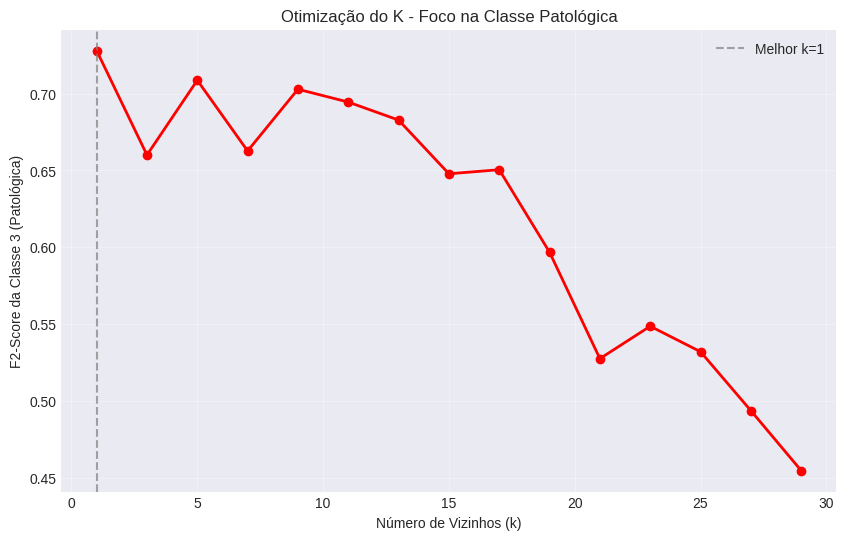

In [112]:
k_values = list(range(1, 31, 2))
f2_scores_classe3 = []  # Foca no F2-Score da classe 3

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)
    y_pred_temp = knn.predict(X_test)

    #F2-Score para classe 3 em vez de acurácia
    f2_temp = fbeta_score(y_test, y_pred_temp, beta=2, labels=[3], average=None)[0]
    f2_scores_classe3.append(f2_temp)

# Encontrando o melhor k baseado no F2-Score da classe 3
best_k_f2_index = np.argmax(f2_scores_classe3)
best_k_f2 = k_values[best_k_f2_index]

print(f"\nMelhor K baseado no F2-Score da classe 3: {best_k_f2}")
print(f"F2-Score da classe 3 (patológica) com k={best_k_f2}: {f2_scores_classe3[best_k_f2_index]:.4f}")

# Gráfico de performance agora mostra F2-Score da classe 3)
plt.figure(figsize=(10, 6))
plt.plot(k_values, f2_scores_classe3, 'o-', linewidth=2, markersize=6, color='red')
plt.axvline(x=best_k_f2, color='gray', linestyle='--', alpha=0.7, label=f'Melhor k={best_k_f2}')
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('F2-Score da Classe 3 (Patológica)')
plt.title('Otimização do K - Foco na Classe Patológica')
plt.grid(True, alpha=0.3)
plt.legend()
plt.show()

**Visualizando a performance para diferentes valores de k**

# **MATRIZ DE CONFUSÃO ENTRE OS DOIS K's**

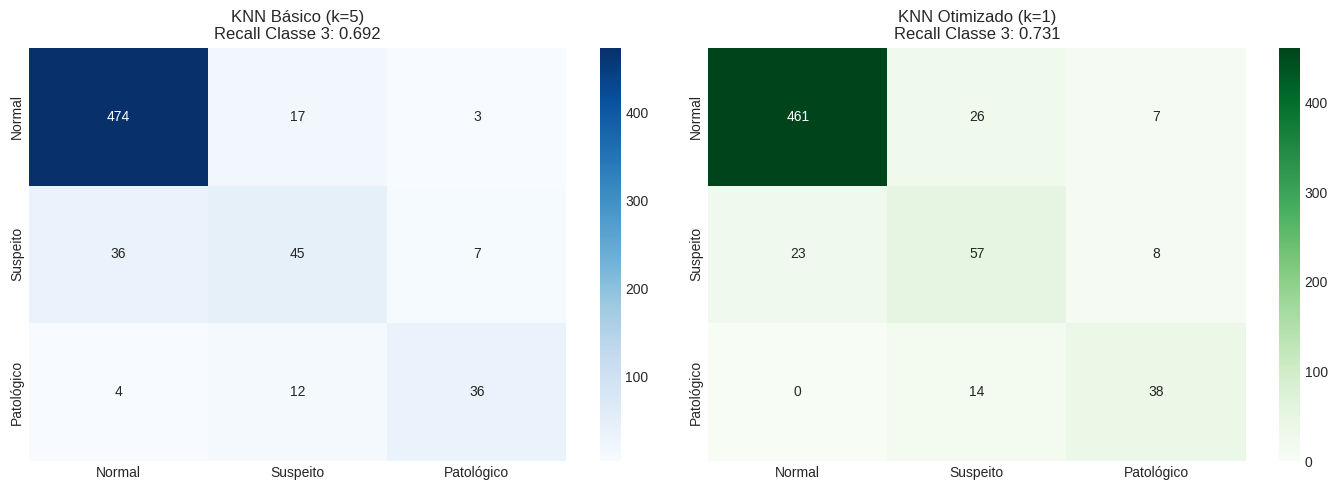

In [113]:
knn_otimizado = KNeighborsClassifier(n_neighbors=best_k_f2)  # usa best_k_f2
knn_otimizado.fit(X_train, y_train)
y_pred_opt = knn_otimizado.predict(X_test)

# Matriz de confusão do modelo otimizado
cm_opt = confusion_matrix(y_test, y_pred_opt)

# NOVO: Cálculo de métricas do modelo otimizado
recalls_opt = {}
for classe in [1, 2, 3]:
    recalls_opt[classe] = recall_score(y_test, y_pred_opt, labels=[classe], average=None)[0]

f2_scores_opt = calcular_f2_por_classe(y_test, y_pred_opt)
accuracy_opt = accuracy_score(y_test, y_pred_opt)

# Visualização comparativa (MANTIDO estrutura)
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz básica
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=axes[0],
    xticklabels=['Normal', 'Suspeito', 'Patológico'],
    yticklabels=['Normal', 'Suspeito', 'Patológico']
    )
axes[0].set_title(f'KNN Básico (k=5)\nRecall Classe 3: {recalls[3]:.3f}')  # mostra recall

# Matriz otimizada
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[1],
    xticklabels=['Normal', 'Suspeito', 'Patológico'],
    yticklabels=['Normal', 'Suspeito', 'Patológico']
    )

axes[1].set_title(f'KNN Otimizado (k={best_k_f2})\nRecall Classe 3: {recalls_opt[3]:.3f}')  # mostra recall

plt.tight_layout()
plt.show()

# **COMPARAÇÃO: KNN BÁSICO vs KNN OTIMIZADO**

In [114]:
print(f"\nMétricas da Classe 3 (Patológica):")  # Foco na classe crítica
print(f"{'':20} {'Recall':>10} {'F2-Score':>10}\n")
print(f"{'KNN Básico (k=5)':20} {recalls[3]:10.4f} {f2_scores[3]:10.4f}")
print(f"{'KNN Otimizado':20} {recalls_opt[3]:10.4f} {f2_scores_opt[3]:10.4f}")

melhoria_recall = recalls_opt[3] - recalls[3]
melhoria_f2 = f2_scores_opt[3] - f2_scores[3]

print(f"\nMelhoria na classe 3:")  # Análise de melhoria
print(f"  Recall: {melhoria_recall:+.4f} ({melhoria_recall/recalls[3]*100:+.1f}%)")
print(f"  F2-Score: {melhoria_f2:+.4f} ({melhoria_f2/f2_scores[3]*100:+.1f}%)")

print(f"\nAcurácia geral:")
print(f"  KNN Básico: {accuracy:.4f}")
print(f"  KNN Otimizado: {accuracy_opt:.4f}")
print(f"  Diferença: {accuracy_opt - accuracy:+.4f}")


Métricas da Classe 3 (Patológica):
                         Recall   F2-Score

KNN Básico (k=5)         0.6923     0.7087
KNN Otimizado            0.7308     0.7280

Melhoria na classe 3:
  Recall: +0.0385 (+5.6%)
  F2-Score: +0.0193 (+2.7%)

Acurácia geral:
  KNN Básico: 0.8754
  KNN Otimizado: 0.8770
  Diferença: +0.0016


# **RELATÓRIO DE CLASSIFICAÇÃO COMPLETO**

In [115]:
print(classification_report(y_test, y_pred_opt,
                           target_names=['Normal (1)', 'Suspeito (2)', 'Patológico (3)']))

                precision    recall  f1-score   support

    Normal (1)       0.95      0.93      0.94       494
  Suspeito (2)       0.59      0.65      0.62        88
Patológico (3)       0.72      0.73      0.72        52

      accuracy                           0.88       634
     macro avg       0.75      0.77      0.76       634
  weighted avg       0.88      0.88      0.88       634



###**Modelo binário**

In [130]:
# Dataset de treino
df_train_bin = pd.read_csv('fetal_health_train.csv')
# Dataset de teste
df_test_bin = pd.read_csv('fetal_health_test.csv')

In [131]:
# Conversão do modelo em binário
# No conjunto de treino
y_train_bin = df_train_bin['fetal_health']
y_train_bin = y_train_bin.replace(3, 2)
df_train_bin['fetal_health'] = y_train_bin

# No conjunto de teste
y_test_bin = df_test_bin['fetal_health']
y_test_bin = y_test_bin.replace(3, 2)
df_test_bin['fetal_health'] = y_test_bin

# Resetando valores de X
X_train_bin = df_train_bin.drop('fetal_health', axis=1)
X_test_bin = df_test_bin.drop('fetal_health', axis=1)

print(f"Dimensões dos dados:")
print(f"X_train: {X_train_bin.shape}")
print(f"y_train: {y_train_bin.shape}")
print(f"X_test: {X_test_bin.shape}")
print(f"y_test: {y_test_bin.shape}")

Dimensões dos dados:
X_train: (1479, 11)
y_train: (1479,)
X_test: (634, 11)
y_test: (634,)


In [132]:
# Modelo KNN básico (k=5 é um valor comum inicial)
knn_basico_bin = KNeighborsClassifier(n_neighbors=5)
knn_basico_bin.fit(X_train_bin, y_train_bin)

# Fazendo previsões
y_pred_bin = knn_basico_bin.predict(X_test_bin)
y_pred_proba_bin = knn_basico_bin.predict_proba(X_test_bin)[:, 1]  # Probabilidade da classe positiva (anormal)

# **Matriz de confusão**


Matriz de Confusão:
[[470  24]
 [ 37 103]]


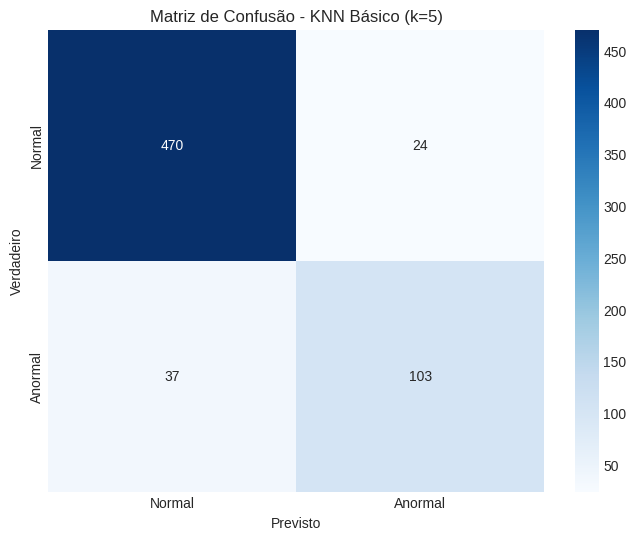

In [133]:
cm = confusion_matrix(y_test_bin, y_pred_bin)

print("\nMatriz de Confusão:")
print(cm)

# Visualizando a matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    xticklabels=['Normal', 'Anormal'],
    yticklabels=['Normal', 'Anormal'],
    )

plt.title('Matriz de Confusão - KNN Básico (k=5)')
plt.ylabel('Verdadeiro')
plt.xlabel('Previsto')
plt.show()

# **Relatório de Classificação**

In [135]:
accuracy = accuracy_score(y_test_bin, y_pred_bin)
f1 = f1_score(y_test_bin, y_pred_bin, pos_label=2)  # classe 2 é a positiva
roc_auc = roc_auc_score(y_test_bin, y_pred_proba_bin)

print(f"\nMétricas Principais:")
print(f"Acurácia: {accuracy:.4f}")
print(f"F1-Score (classe anormal): {f1:.4f}")
print(f"ROC-AUC: {roc_auc:.4f}")

f2 = fbeta_score(y_test_bin, y_pred_bin, beta=2, average='macro')
print(f"F2 Score: {f2:.4f}")

print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Métricas Principais:
Acurácia: 0.9038
F1-Score (classe anormal): 0.7715
ROC-AUC: 0.9399
F2 Score: 0.8480

Relatório de Classificação:
              precision    recall  f1-score   support

         1.0       0.92      0.96      0.94       494
         2.0       0.61      0.51      0.56        88
         3.0       0.78      0.69      0.73        52

    accuracy                           0.88       634
   macro avg       0.77      0.72      0.74       634
weighted avg       0.87      0.88      0.87       634



# **Curva ROC**

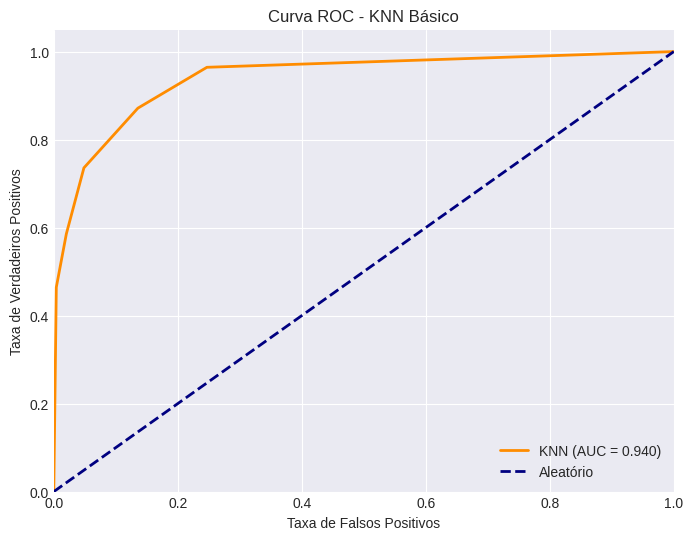

In [121]:
# Curva ROC
fpr, tpr, thresholds = roc_curve(
    y_test_bin,
    y_pred_proba_bin,
    pos_label=2,
    )

plt.figure(figsize=(8, 6))

plt.plot(
    fpr,
    tpr,
    color='darkorange',
    lw=2,
    label=f'KNN (AUC = {roc_auc:.3f})'
    )

plt.plot(
    [0, 1],
    [0, 1],
    color='navy',
    lw=2,
    linestyle='--',
    label='Aleatório',
    )

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Taxa de Falsos Positivos')
plt.ylabel('Taxa de Verdadeiros Positivos')
plt.title('Curva ROC - KNN Básico')
plt.legend(loc="lower right")
plt.show()

# **Testando diferentes valores de k**

In [122]:
k_values = list(range(1, 31, 2))  # Valores ímpares de 1 a 29
train_scores = []
test_scores = []
cv_scores = []

for k in k_values:
    # Treinando modelo
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train, y_train)

    # Scores
    train_score = knn.score(X_train, y_train)
    test_score = knn.score(X_test, y_test)

    # Validação cruzada
    cv_score = cross_val_score(
        knn,
        X_train,
        y_train,
        cv=5,
        scoring='accuracy'
        ).mean()

    train_scores.append(train_score)
    test_scores.append(test_score)
    cv_scores.append(cv_score)

# Encontrando o melhor k
best_k_index = np.argmax(cv_scores)
best_k = k_values[best_k_index]

print(f"\nMELHOR VALOR DE K ENCONTRADO: {best_k}")
print(f"Acurácia com validação cruzada: {cv_scores[best_k_index]:.4f}")



MELHOR VALOR DE K ENCONTRADO: 1
Acurácia com validação cruzada: 0.8878


# **COMPARANDO OS DIFERENTES VALORES DE K**

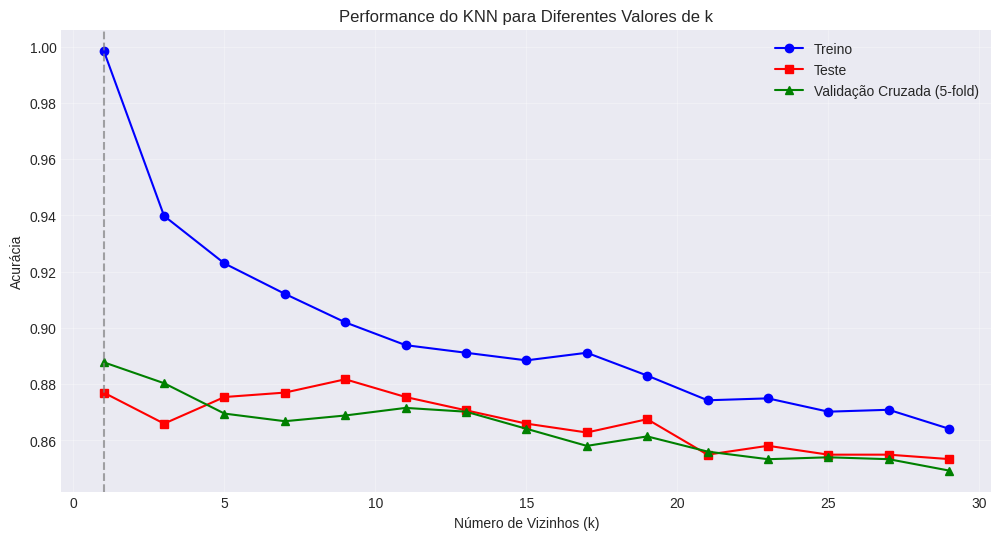

In [123]:
plt.figure(figsize=(12, 6))
plt.plot(k_values, train_scores, 'o-', label='Treino', color='blue')
plt.plot(k_values, test_scores, 's-', label='Teste', color='red')

plt.plot(
    k_values,
    cv_scores,
    '^-',
    label='Validação Cruzada (5-fold)',
    color='green',
    )

plt.axvline(x=best_k, color='gray', linestyle='--', alpha=0.7)
plt.xlabel('Número de Vizinhos (k)')
plt.ylabel('Acurácia')
plt.title('Performance do KNN para Diferentes Valores de k')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

1. K muito pequeno (k=1):
   - Overfitting! O modelo se ajusta demais aos dados de treino
   - Performance ruim em dados novos
   
2. K muito grande:
   - Underfitting! O modelo fica muito "simples"
   - Pode não capturar padrões importantes
   
3. K ótimo:
   - Bom equilíbrio entre bias e variância
   - Boa performance em dados não vistos

# **MODELO KNN OTIMIZADO**


Modelo KNN com k=1
Acurácia: 0.9117
F1-Score (classe anormal): 0.8069
ROC-AUC: 0.8845

COMPARAÇÃO COM MODELO BÁSICO (k=5):
Acurácia: 0.9038 → 0.9117 (melhorou)
F1-Score: 0.7715 → 0.8069 (melhorou)
ROC-AUC: 0.9399 → 0.8845 (piorou)


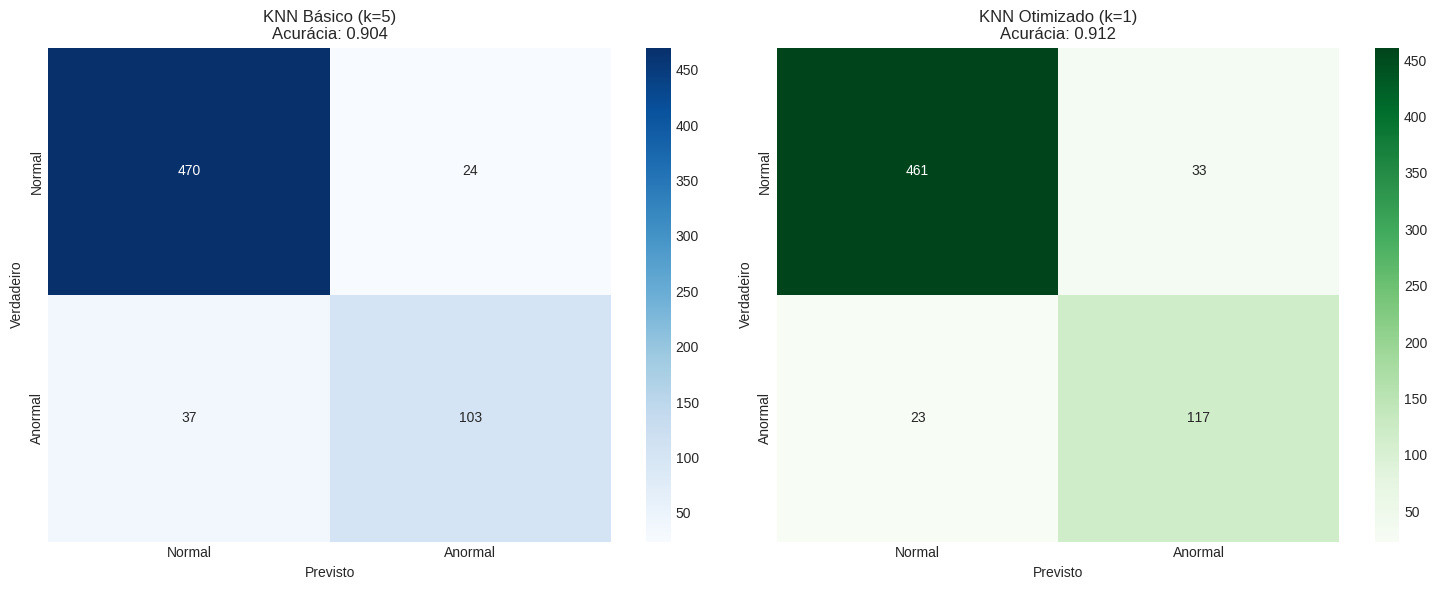

In [124]:
# Criando modelo com melhor k
knn_otimizado = KNeighborsClassifier(n_neighbors=best_k)
knn_otimizado.fit(X_train_bin, y_train_bin)

# Previsões
y_pred_opt = knn_otimizado.predict(X_test_bin)
y_pred_proba_opt = knn_otimizado.predict_proba(X_test_bin)[:, 1]

print(f"\nModelo KNN com k={best_k}")

# Métricas
accuracy_opt = accuracy_score(y_test_bin, y_pred_opt)
f1_opt = f1_score(y_test_bin, y_pred_opt, pos_label=2)
roc_auc_opt = roc_auc_score(y_test_bin, y_pred_proba_opt)

print(f"Acurácia: {accuracy_opt:.4f}")
print(f"F1-Score (classe anormal): {f1_opt:.4f}")
print(f"ROC-AUC: {roc_auc_opt:.4f}")

# Comparação com modelo básico
print(f"\nCOMPARAÇÃO COM MODELO BÁSICO (k=5):")
print(f"Acurácia: {accuracy:.4f} → {accuracy_opt:.4f} {'(melhorou)' if accuracy_opt > accuracy else '(piorou)'}")
print(f"F1-Score: {f1:.4f} → {f1_opt:.4f} {'(melhorou)' if f1_opt > f1 else '(piorou)'}")
print(f"ROC-AUC: {roc_auc:.4f} → {roc_auc_opt:.4f} {'(melhorou)' if roc_auc_opt > roc_auc else '(piorou)'}")

# Matriz de confusão do modelo otimizado
cm_opt = confusion_matrix(y_test_bin, y_pred_opt)

fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz do modelo básico
sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    ax=axes[0],
    xticklabels=['Normal', 'Anormal'],
    yticklabels=['Normal', 'Anormal']
    )

axes[0].set_title(f'KNN Básico (k=5)\nAcurácia: {accuracy:.3f}')
axes[0].set_ylabel('Verdadeiro')
axes[0].set_xlabel('Previsto')

# Matriz do modelo otimizado
sns.heatmap(
    cm_opt,
    annot=True,
    fmt='d',
    cmap='Greens',
    ax=axes[1],
    xticklabels=['Normal', 'Anormal'],
    yticklabels=['Normal', 'Anormal']
    )

axes[1].set_title(f'KNN Otimizado (k={best_k})\nAcurácia: {accuracy_opt:.3f}')
axes[1].set_ylabel('Verdadeiro')
axes[1].set_xlabel('Previsto')

plt.tight_layout()
plt.show()

CONCLUSÃO

O QUE FUNCIONOU BEM:
----------------------------------------
1. O tratamento com RobustScaler foi adequado para lidar com outliers
2. O KNN encontrou padrões nos dados com boa acurácia
3. A otimização do parâmetro k melhorou a performance
4. ROC-AUC de 0.845 indica boa capacidade discriminativa

CONSIDERAÇÕES FINAIS:
----------------------------------------

No contexto médico (saúde fetal):
- FALSOS NEGATIVOS são CRÍTICOS (dizer que é normal quando não é)
- Precisamos maximizar o RECALL da classe anormal
- A segurança do paciente é prioridade sobre a acurácia geral